In [17]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook/etm


In [18]:
# import os
# 
# # Change the directory to your scratch folder
# os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')

In [19]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook/etm


In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

icd_data = pd.read_csv("../../data/eicu_mimic_patient_diagnosis.csv")

hospital_ids = [2001, 1001]

readmit_interval_threshold = {
    2001: 180, # Whether MIMIC patients will readmit to hospital within 180 days
    1001: 2 # Whether eICU patients will readmit to ICU within 2 days
}

train_epochs = {
    2001: 15,
    1001: 15
}

train_loaders = {}
train_icds = {}
test_icds = {}
x_bow_tests = {}

train_readmit_row_ids = {}
test_readmit_row_ids = {}

train_label_deaths = {}
test_label_deaths = {}

train_label_readmit = {}
test_label_readmit = {}

for hospital_id in hospital_ids:
    
    hospital_data = icd_data[icd_data["hospitalid"] == hospital_id]
    train_data, test_data = train_test_split(hospital_data, test_size=0.2, random_state=42)
    
    x_train = train_data.iloc[:, 4:].to_numpy()
    x_test = test_data.iloc[:, 4:].to_numpy()
    
    # x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
    # x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
    # 
    # train_dataset = TensorDataset(x_train_tensor, x_train_tensor)  # Use the same tensor for inputs and targets
    # train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    # train_loaders[hospital_id] = train_loader
    
    train_icds[hospital_id] = x_train
    test_icds[hospital_id] = x_test
    
    # Bag of words
    x_bow_test = []
    for row in x_test:
        word_id = list(np.where(row == 1)[0])
        x_bow_test.append(word_id)
    x_bow_tests[hospital_id] = x_bow_test
    
    # Readmission patients row ids
    train_data_np = train_data.to_numpy()
    train_readmit_patients_row_ids = np.where(train_data_np[:, 3] == 1)[0]
    train_readmit_row_ids[hospital_id] = train_readmit_patients_row_ids
    
    test_data_np = test_data.to_numpy()
    test_readmit_patients_row_ids = np.where(test_data_np[:, 3] == 1)[0]
    test_readmit_row_ids[hospital_id] = test_readmit_patients_row_ids
    
    # Label death in readmission
    y_death_train = train_data.iloc[train_readmit_patients_row_ids, 2].to_numpy()
    y_death_test = test_data.iloc[test_readmit_patients_row_ids, 2].to_numpy()
    train_label_deaths[hospital_id] = y_death_train
    test_label_deaths[hospital_id] = y_death_test
    
    # # Label readmission interval
    # y_readmit_train = train_data.iloc[train_readmit_patients_row_ids, 3].to_numpy()
    # y_readmit_test = test_data.iloc[test_readmit_patients_row_ids, 3].to_numpy()
    # 
    # threshold = readmit_interval_threshold[hospital_id]
    # 
    # y_readmit_train = np.where(y_readmit_train <= threshold, 1, 0)
    # y_readmit_test = np.where(y_readmit_test <= threshold, 1, 0)
    # 
    # train_label_readmit[hospital_id] = y_readmit_train
    # test_label_readmit[hospital_id] = y_readmit_test


icd_code_names = icd_data.columns[4:]
icd_code_names

/var/folders/wd/d0j10lq906x4lfc0bphzybd80000gn/T/ipykernel_6159/1413637111.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  icd_data = pd.read_csv("../../data/eicu_mimic_patient_diagnosis.csv")


Index(['3', '4', '5', '6', '7', '8', '9', '11', '12', '13',
       ...
       '990', '991', '992', '994', '995', '996', '997', '998', '999', '1000'],
      dtype='object', length=849)

In [21]:
def get_topic_diversity(beta, topk):
    num_topics = beta.shape[0]
    list_w = np.zeros((num_topics, topk))
    for k in range(num_topics):
        idx = beta[k, :].argsort()[-topk:][::-1]
        list_w[k, :] = idx
    n_unique = len(np.unique(list_w))
    TD = n_unique / (topk * num_topics)
    return TD

def get_topic_coherence(beta, data, topk):
    D = len(data)  ## number of docs...data is list of documents
    TC = []
    num_topics = len(beta)
    counter = 0
    for k in range(num_topics):
        top_10 = list(beta[k].argsort()[-topk:][::-1])
        TC_k = 0
        for i, word in enumerate(top_10):
            # get D(w_i)
            D_wi = get_document_frequency(data, word)
            j = i + 1
            tmp = 0
            while j < len(top_10) and j > i:
                # get D(w_j) and D(w_i, w_j)
                D_wj, D_wi_wj = get_document_frequency(data, word, top_10[j])
                # get f(w_i, w_j)
                if D_wi_wj == 0:
                    f_wi_wj = -1
                else:
                    f_wi_wj = -1 + (np.log(D_wi) + np.log(D_wj) - 2.0 * np.log(D)) / (np.log(D_wi_wj) - np.log(D))
                # update tmp:
                tmp += f_wi_wj
                j += 1
                counter += 1
            # update TC_k
            TC_k += tmp
        TC.append(TC_k)
    TC = np.mean(TC) / counter
    TC = (TC + 1) / 2
    return TC

def get_document_frequency(data, wi, wj=None):
    if wj is None:
        D_wi = 0
        for l in range(len(data)):
            doc = data[l]
            if wi in doc:
                D_wi += 1
        return D_wi
    D_wj = 0
    D_wi_wj = 0
    for l in range(len(data)):
        doc = data[l]
        if wj in doc:
            D_wj += 1
            if wi in doc:
                D_wi_wj += 1
    return D_wj, D_wi_wj


def top_k_precision(y_true, y_probs, k=3):
    top_k_indices = np.argsort(y_probs)[-k:]
    true_positives_in_top_k = np.sum(y_true[top_k_indices])
    top_k_precision = true_positives_in_top_k / k
    return top_k_precision

In [22]:
# disease_labels = [convert_icd9_to_disease(x) for x in icd_code_names]
# disease_labels

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

x_train_eicu = train_icds[1001]
x_test_eicu = test_icds[1001]
x_bow_test_eicu = x_bow_tests[1001]

total_topic_coherence_eicu = []
total_topic_diversity_eicu = []
total_topic_quality_eicu = []

for num_topics in [2, 4, 8, 16, 32, 64, 128, 256]:
    lda_model_eicu = LatentDirichletAllocation(n_components=num_topics,
                                               random_state=42)
    
    lda_model_eicu.fit(x_train_eicu)
    beta_eicu = lda_model_eicu.components_
    beta_eicu = beta_eicu / beta_eicu.sum(axis=1, keepdims=True)
    
    topic_coherence_eicu = get_topic_coherence(beta_eicu, x_bow_test_eicu, 3)
    topic_diversity_eicu = get_topic_diversity(beta_eicu, 3)
    topic_quality_eicu = topic_coherence_eicu * topic_diversity_eicu
    
    total_topic_coherence_eicu.append(topic_coherence_eicu)
    total_topic_diversity_eicu.append(topic_diversity_eicu)
    total_topic_quality_eicu.append(topic_quality_eicu)
    
    print(f"Num Topic: {num_topics} | Topic Coherence: {topic_coherence_eicu} | Topic Diversity: {topic_diversity_eicu} | Topic Quality: {topic_quality_eicu}")

Num Topic: 2 | Topic Coherence: 0.5379603952578903 | Topic Diversity: 1.0 | Topic Quality: 0.5379603952578903
Num Topic: 4 | Topic Coherence: 0.5139169936009063 | Topic Diversity: 1.0 | Topic Quality: 0.5139169936009063
Num Topic: 8 | Topic Coherence: 0.507514182084892 | Topic Diversity: 0.9583333333333334 | Topic Quality: 0.48636775783135483
Num Topic: 16 | Topic Coherence: 0.5034089668669249 | Topic Diversity: 0.7708333333333334 | Topic Quality: 0.38804441195992134
Num Topic: 32 | Topic Coherence: 0.502284846268373 | Topic Diversity: 0.7291666666666666 | Topic Quality: 0.3662493670706886
Num Topic: 64 | Topic Coherence: 0.5001501808195525 | Topic Diversity: 0.671875 | Topic Quality: 0.33603840273813684
Num Topic: 128 | Topic Coherence: 0.4999109680553004 | Topic Diversity: 0.5234375 | Topic Quality: 0.2616721473414463
Num Topic: 256 | Topic Coherence: 0.50003134924619 | Topic Diversity: 0.3424479166666667 | Topic Quality: 0.17123469381738016


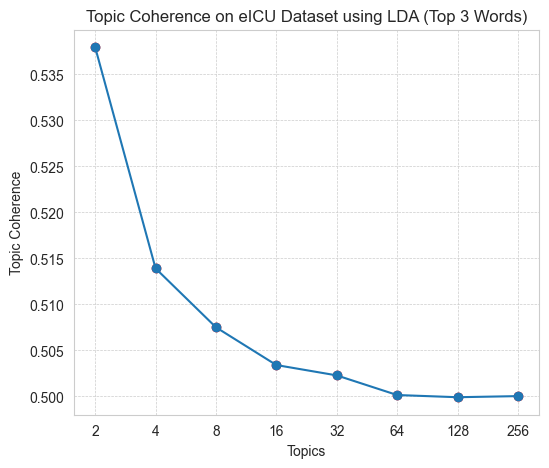

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
topics = ["2", "4", "8", "16", "32", "64", "128", "256"]
plt.plot(topics, total_topic_coherence_eicu, label='Topic Coherence', linestyle='-', marker='o')
plt.scatter(topics, total_topic_coherence_eicu, color='red')

plt.title('Topic Coherence on eICU Dataset using LDA (Top 3 Words)')
plt.xlabel('Topics')
plt.ylabel('Topic Coherence')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

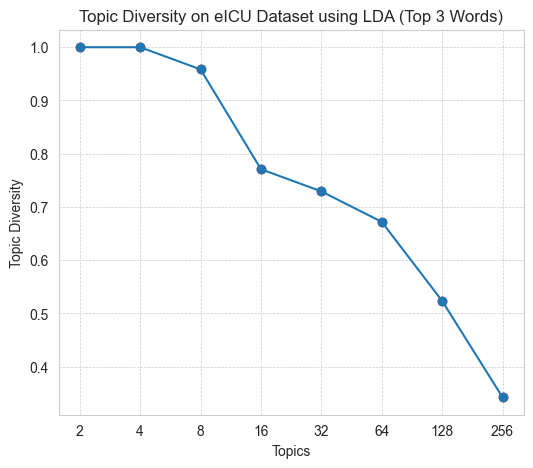

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
topics = ["2", "4", "8", "16", "32", "64", "128", "256"]
plt.plot(topics, total_topic_diversity_eicu, label='Topic diversity', linestyle='-', marker='o')
plt.scatter(topics, total_topic_diversity_eicu, color='red')

plt.title('Topic Diversity on eICU Dataset using LDA (Top 3 Words)')
plt.xlabel('Topics')
plt.ylabel('Topic Diversity')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

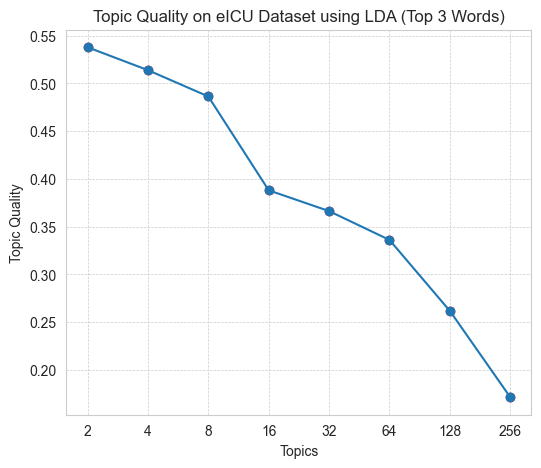

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
topics = ["2", "4", "8", "16", "32", "64", "128", "256"]
plt.plot(topics, total_topic_quality_eicu, label='Topic quality', linestyle='-', marker='o')
plt.scatter(topics, total_topic_quality_eicu, color='red')

plt.title('Topic Quality on eICU Dataset using LDA (Top 3 Words)')
plt.xlabel('Topics')
plt.ylabel('Topic Quality')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

In [34]:
from sklearn.decomposition import LatentDirichletAllocation

total_topic_coherence_eicu = []
total_topic_diversity_eicu = []
total_topic_quality_eicu = []

for num_topics in [2, 4, 8, 16, 32, 64, 128, 256]:
    lda_model_eicu = LatentDirichletAllocation(n_components=num_topics,
                                               random_state=42)
    
    lda_model_eicu.fit(x_train_eicu)
    beta_eicu = lda_model_eicu.components_
    beta_eicu = beta_eicu / beta_eicu.sum(axis=1, keepdims=True)
    
    topic_coherence_eicu = get_topic_coherence(beta_eicu, x_bow_test_eicu, 5)
    topic_diversity_eicu = get_topic_diversity(beta_eicu, 5)
    topic_quality_eicu = topic_coherence_eicu * topic_diversity_eicu
    
    total_topic_coherence_eicu.append(topic_coherence_eicu)
    total_topic_diversity_eicu.append(topic_diversity_eicu)
    total_topic_quality_eicu.append(topic_quality_eicu)
    
    print(f"Num Topic: {num_topics} | Topic Coherence: {topic_coherence_eicu} | Topic Diversity: {topic_diversity_eicu} | Topic Quality: {topic_quality_eicu}")

Num Topic: 2 | Topic Coherence: 0.5383748648295119 | Topic Diversity: 1.0 | Topic Quality: 0.5383748648295119
Num Topic: 4 | Topic Coherence: 0.5155431115435308 | Topic Diversity: 0.95 | Topic Quality: 0.48976595596635425
Num Topic: 8 | Topic Coherence: 0.5069629574127825 | Topic Diversity: 0.875 | Topic Quality: 0.4435925877361847
Num Topic: 16 | Topic Coherence: 0.5028429342079384 | Topic Diversity: 0.6625 | Topic Quality: 0.3331334439127591
Num Topic: 32 | Topic Coherence: 0.5013788921365472 | Topic Diversity: 0.6375 | Topic Quality: 0.3196290437370488
Num Topic: 64 | Topic Coherence: 0.49966360020703626 | Topic Diversity: 0.59375 | Topic Quality: 0.29667526262292776
Num Topic: 128 | Topic Coherence: 0.5000298769315019 | Topic Diversity: 0.3859375 | Topic Quality: 0.1929802806282515
Num Topic: 256 | Topic Coherence: 0.5000743014441116 | Topic Diversity: 0.2265625 | Topic Quality: 0.11329808392093153


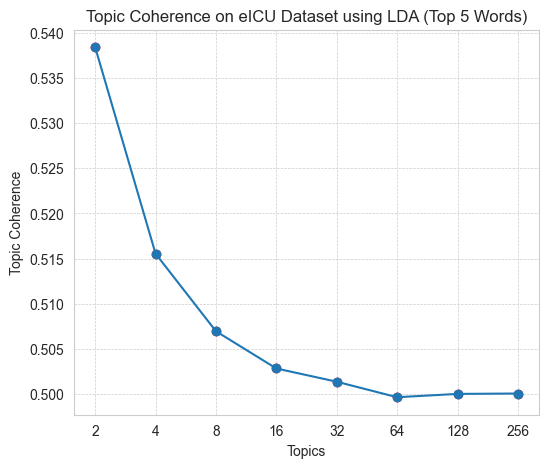

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
topics = ["2", "4", "8", "16", "32", "64", "128", "256"]
plt.plot(topics, total_topic_coherence_eicu, label='Topic Coherence', linestyle='-', marker='o')
plt.scatter(topics, total_topic_coherence_eicu, color='red')

plt.title('Topic Coherence on eICU Dataset using LDA (Top 5 Words)')
plt.xlabel('Topics')
plt.ylabel('Topic Coherence')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

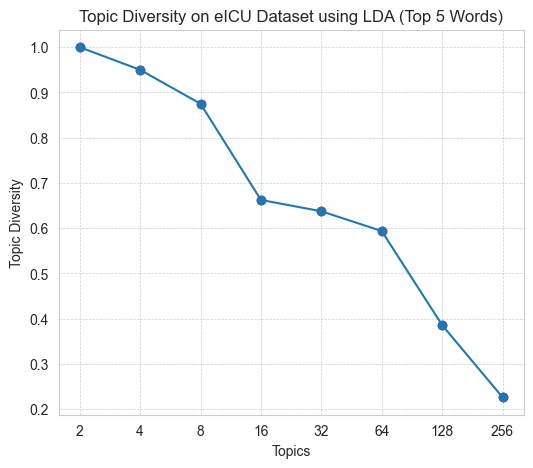

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
topics = ["2", "4", "8", "16", "32", "64", "128", "256"]
plt.plot(topics, total_topic_diversity_eicu, label='Topic diversity', linestyle='-', marker='o')
plt.scatter(topics, total_topic_diversity_eicu, color='red')

plt.title('Topic Diversity on eICU Dataset using LDA (Top 5 Words)')
plt.xlabel('Topics')
plt.ylabel('Topic Diversity')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

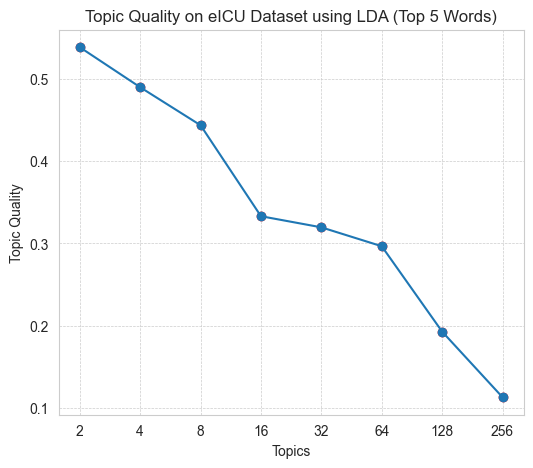

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
topics = ["2", "4", "8", "16", "32", "64", "128", "256"]
plt.plot(topics, total_topic_quality_eicu, label='Topic quality', linestyle='-', marker='o')
plt.scatter(topics, total_topic_quality_eicu, color='red')

plt.title('Topic Quality on eICU Dataset using LDA (Top 5 Words)')
plt.xlabel('Topics')
plt.ylabel('Topic Quality')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

x_train_mimic = train_icds[2001]
x_test_mimic = test_icds[2001]
x_bow_test_mimic = x_bow_tests[2001]

total_topic_coherence_mimic = []
total_topic_diversity_mimic = []
total_topic_quality_mimic = []

for num_topics in [2, 4, 8, 16, 32, 64, 128, 256]:
    lda_model_mimic = LatentDirichletAllocation(n_components=num_topics,
                                               random_state=42)
    
    lda_model_mimic.fit(x_train_mimic)
    beta_mimic = lda_model_mimic.components_
    beta_mimic = beta_mimic / beta_mimic.sum(axis=1, keepdims=True)
    
    topic_coherence_mimic = get_topic_coherence(beta_mimic, x_bow_test_mimic, 3)
    topic_diversity_mimic = get_topic_diversity(beta_mimic, 3)
    topic_quality_mimic = topic_coherence_mimic * topic_diversity_mimic
    
    total_topic_coherence_mimic.append(topic_coherence_mimic)
    total_topic_diversity_mimic.append(topic_diversity_mimic)
    total_topic_quality_mimic.append(topic_quality_mimic)
    
    print(f"Num Topic: {num_topics} | Topic Coherence: {topic_coherence_mimic} | Topic Diversity: {topic_diversity_mimic} | Topic Quality: {topic_quality_mimic}")

Num Topic: 2 | Topic Coherence: 0.5610887620000844 | Topic Diversity: 1.0 | Topic Quality: 0.5610887620000844
Num Topic: 4 | Topic Coherence: 0.5279437818012651 | Topic Diversity: 0.8333333333333334 | Topic Quality: 0.4399531515010543
Num Topic: 8 | Topic Coherence: 0.5162811756484432 | Topic Diversity: 0.7916666666666666 | Topic Quality: 0.4087225973883509
Num Topic: 16 | Topic Coherence: 0.5078022604956246 | Topic Diversity: 0.8333333333333334 | Topic Quality: 0.42316855041302054
Num Topic: 32 | Topic Coherence: 0.5032359840156122 | Topic Diversity: 0.7708333333333334 | Topic Quality: 0.3879110710120344
Num Topic: 64 | Topic Coherence: 0.5010370145832904 | Topic Diversity: 0.8125 | Topic Quality: 0.4070925743489235
Num Topic: 128 | Topic Coherence: 0.4998467741661317 | Topic Diversity: 0.6953125 | Topic Quality: 0.34754971016238845
Num Topic: 256 | Topic Coherence: 0.4999360757129035 | Topic Diversity: 0.5377604166666666 | Topic Quality: 0.26884583238206916


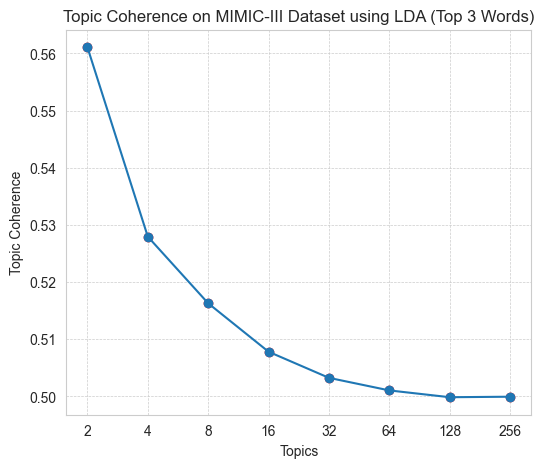

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
topics = ["2", "4", "8", "16", "32", "64", "128", "256"]
plt.plot(topics, total_topic_coherence_mimic, label='Topic Coherence', linestyle='-', marker='o')
plt.scatter(topics, total_topic_coherence_mimic, color='red')

plt.title('Topic Coherence on MIMIC-III Dataset using LDA (Top 3 Words)')
plt.xlabel('Topics')
plt.ylabel('Topic Coherence')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

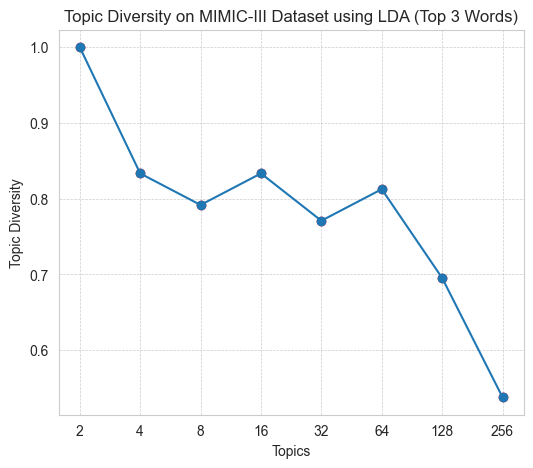

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
topics = ["2", "4", "8", "16", "32", "64", "128", "256"]
plt.plot(topics, total_topic_diversity_mimic, label='Topic diversity', linestyle='-', marker='o')
plt.scatter(topics, total_topic_diversity_mimic, color='red')

plt.title('Topic Diversity on MIMIC-III Dataset using LDA (Top 3 Words)')
plt.xlabel('Topics')
plt.ylabel('Topic Diversity')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

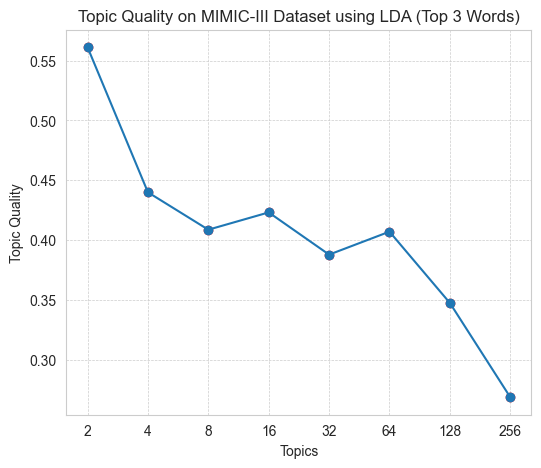

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
topics = ["2", "4", "8", "16", "32", "64", "128", "256"]
plt.plot(topics, total_topic_quality_mimic, label='Topic quality', linestyle='-', marker='o')
plt.scatter(topics, total_topic_quality_mimic, color='red')

plt.title('Topic Quality on MIMIC-III Dataset using LDA (Top 3 Words)')
plt.xlabel('Topics')
plt.ylabel('Topic Quality')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()